In [1]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_100000.h5 and others can be downloaded from mentioned website.

In [4]:
from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


dots_set, dots_files = load_images(DOTS_SRC)
tracks_set, tacks_files = load_images(TRACKS_SRC)
worms_set, worms_files = load_images(WORMS_SRC)

tracks_set = np.vstack([tracks_set, dots_set])
tacks_files = np.hstack([tacks_files, dots_files])

In [5]:
def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug


tracks2_set, tacks2_files = augmentation_mirror(tracks_set, tacks_files)
worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)

In [6]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test


tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)

320
0
128
18496
0
256
0
230416
244800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0 

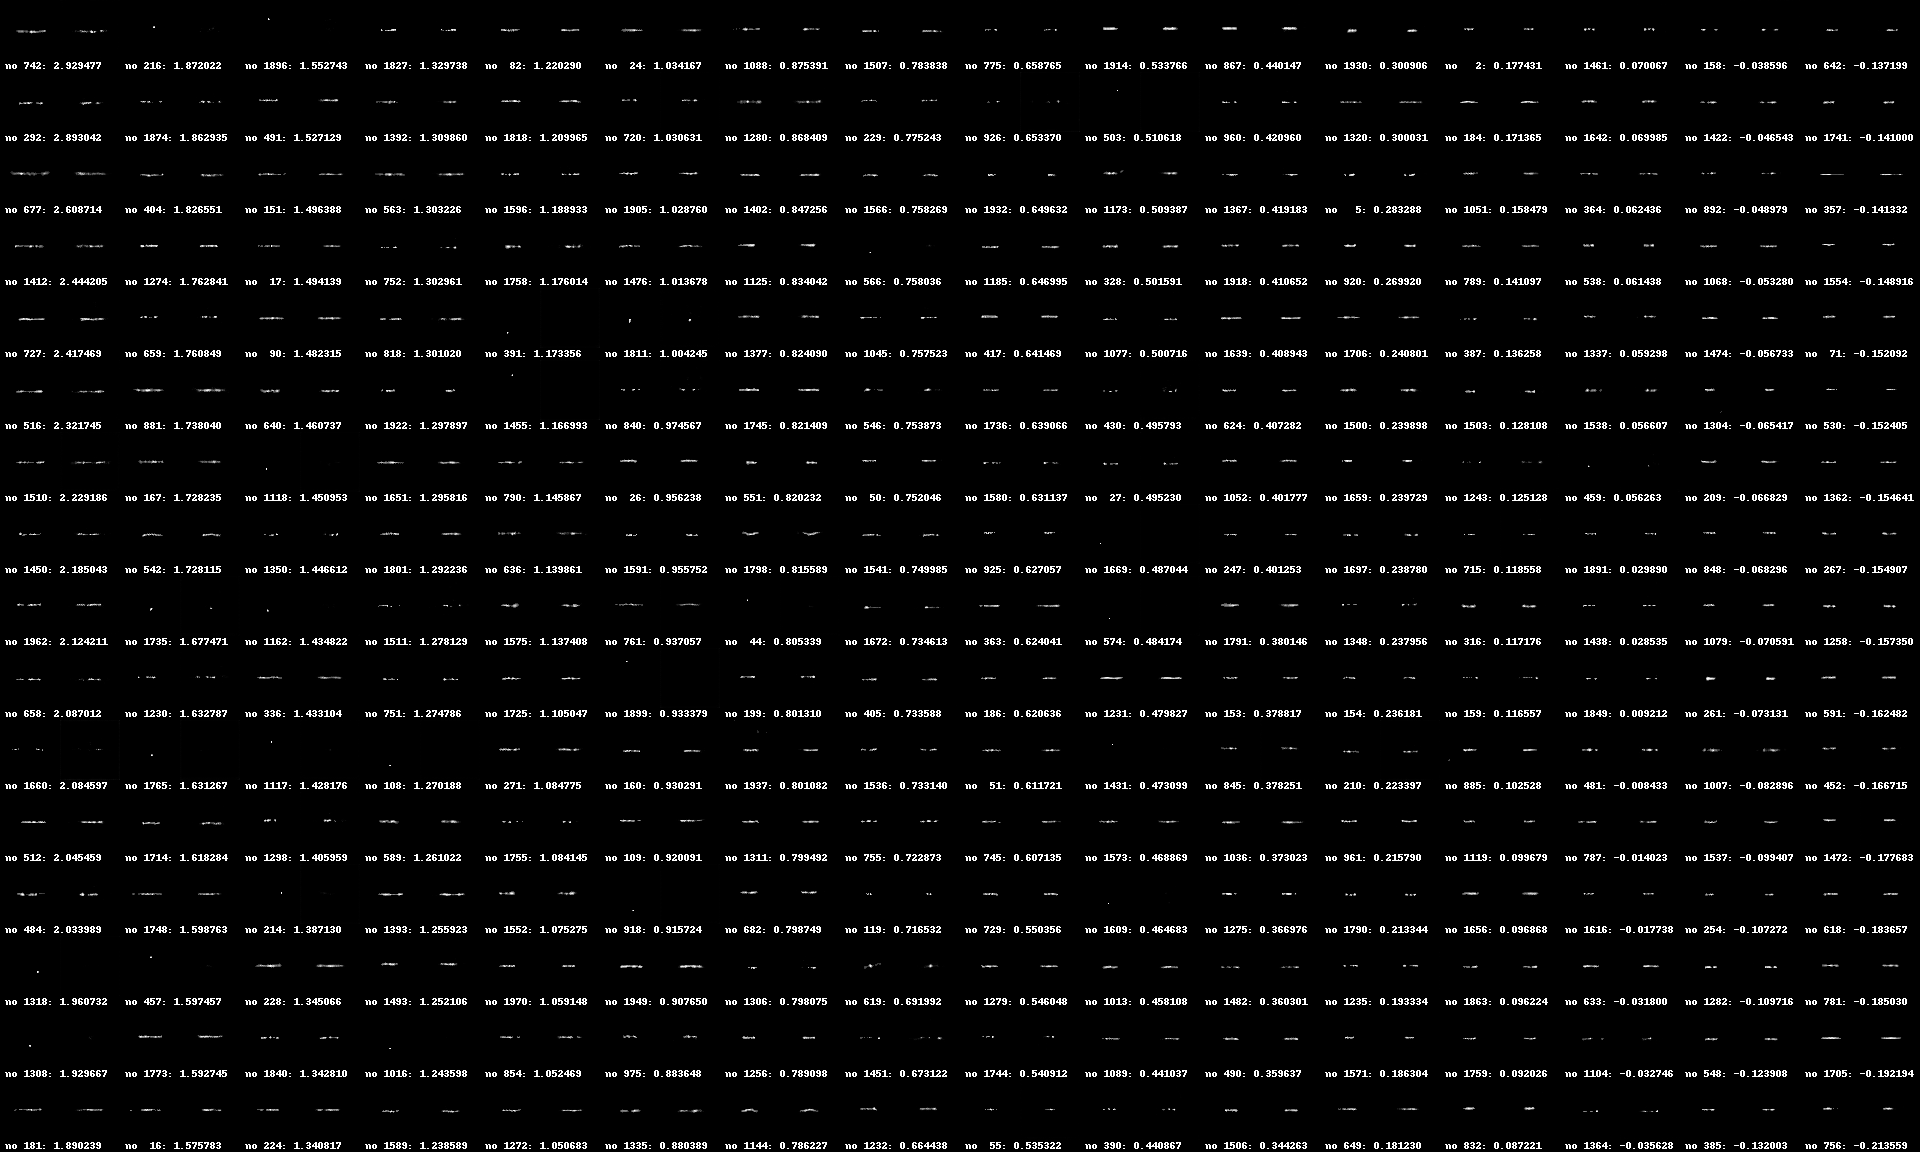

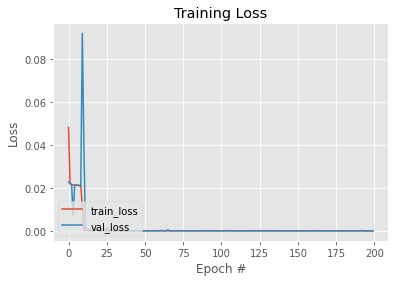

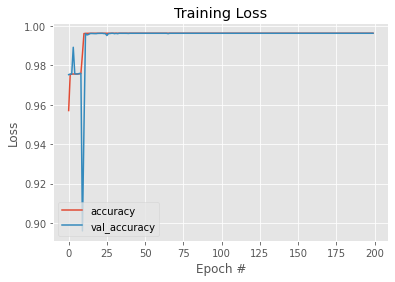

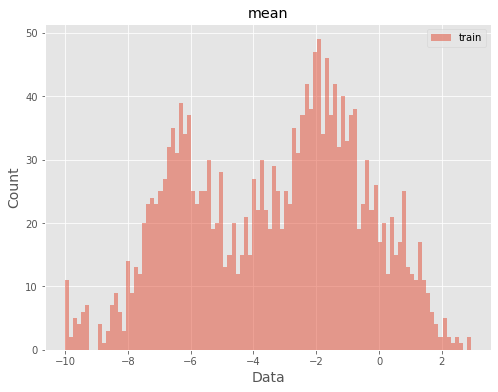

In [7]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/th_dots_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'

def train_and_test(train_set, validation_set, fn):
    autoencoder = original_autoencoder()
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC)

In [8]:
from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

In [9]:
def dbscan(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()


[0 0 0 ... 0 0 0]
[   6   18   30   50   90   97  108  123  131  158  163  175  177  179
  187  214  221  222  232  274  278  280  292  309  341  363  365  371
  383  384  397  411  418  436  444  448  450  473  476  478  500  511
  515  520  528  536  537  546  549  583  596  606  657  659  672  684
  693  713  714  718  722  739  750  760  777  779  783  786  798  804
  812  819  840  871  948  967  969 1008 1019 1024 1032 1072 1105 1127
 1151 1232 1250 1269 1284 1288 1318 1342 1354 1361 1371 1375 1379 1402
 1410 1428 1432 1456 1462 1491 1497 1499 1503 1510 1512 1527 1541 1545
 1550 1558 1565 1567 1617 1619 1631 1635 1637 1647 1659 1681 1685 1692
 1710 1716 1732 1748 1754 1760 1823 1825 1831 1839 1842 1844 1867 1884
 1932 1949 1967]
143
hit-images-final2/line\23447830.png
hit-images-final2/line\22753566.png
hit-images-final2/line\13894279.png
hit-images-final2/line\21978364.png
hit-images-final2/line\22262071.png
hit-images-final2/line\23769522.png
hit-images-final2/line\22345563.png

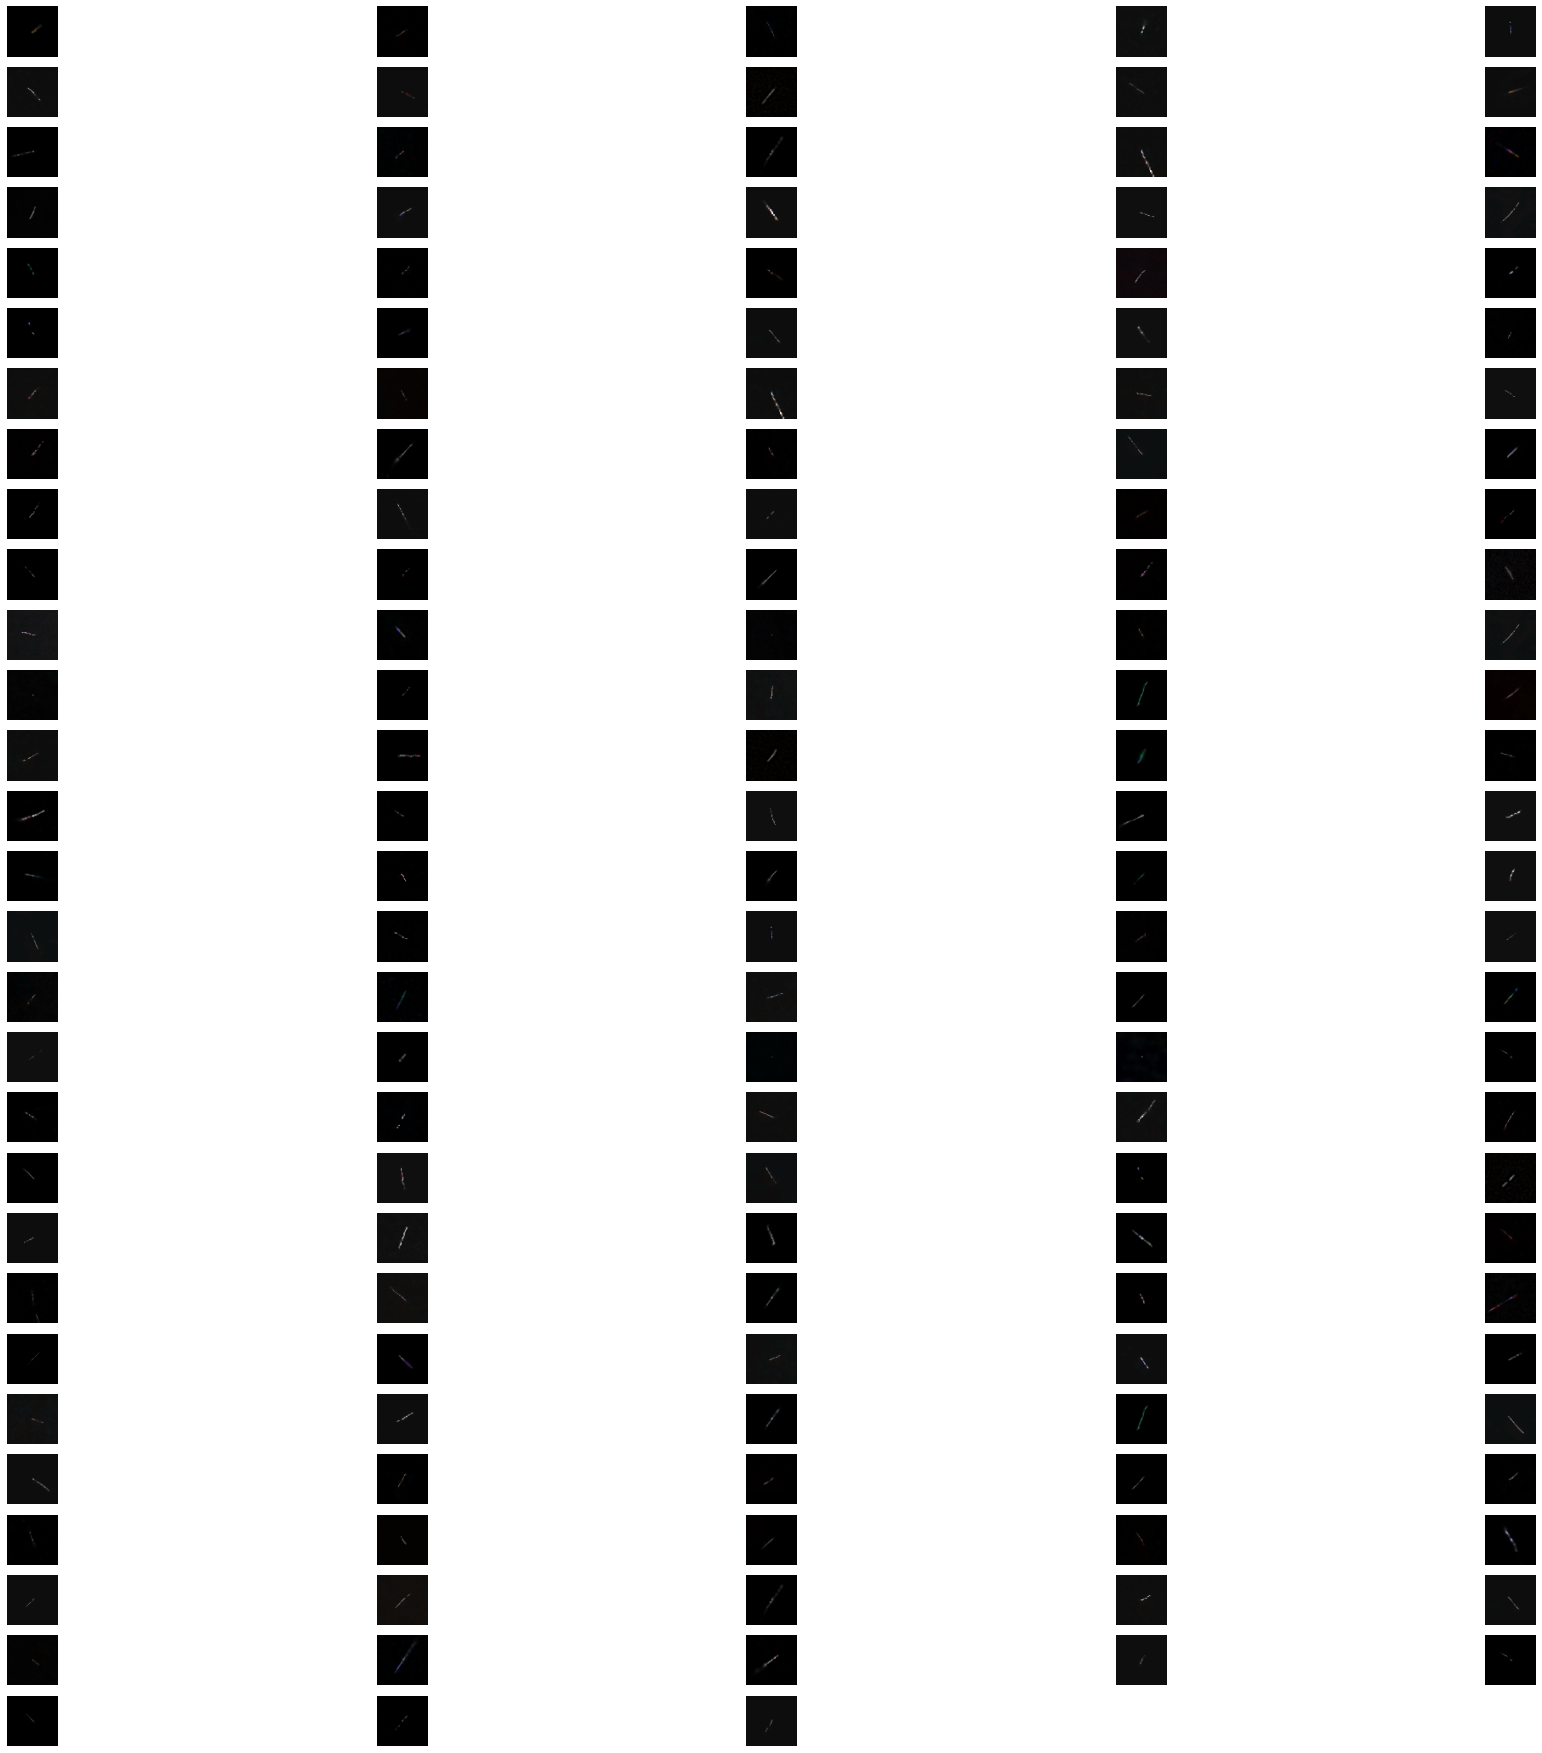

In [10]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
dbscan(tracks_embedding, tracks_t_files, 120)

[ 0  0  0 ... -1  0 -1]
[  90  108  131  175  177  179  221  274  278  280  292  363  371  383
  418  476  500  520  536  537  546  606  672  684  714  722  739  777
  779  798  969 1008 1032 1127 1318 1354 1361 1402 1410 1428 1456 1527
 1565 1631 1692 1754 1760 1823 1839 1842 1844 1981 1988 1991 1995 1999
 2001 2002 2007 2012 2015 2017 2018 2019 2024 2025 2026 2029 2030 2031
 2042 2043 2045 2046 2048 2049 2050 2052 2053 2055 2058 2059 2060 2061
 2064 2065 2068 2069 2070 2071 2072 2075 2079 2080 2081 2090 2091 2094
 2095 2105 2108 2115 2116 2120 2121 2125 2126 2128 2129 2135 2136 2137
 2139 2144 2149 2153 2158 2172 2174]
119
hit-images-final2/line\22262071.png
hit-images-final2/line\22345563.png
hit-images-final2/line\24274103.png
hit-images-final2/line\12006113.png
hit-images-final2/line\22437099.png
hit-images-final2/line\11858430.png
hit-images-final2/line\23295039.png
hit-images-final2/line\11802060.png
hit-images-final2/line\13873250.png
hit-images-final2/line\22269647.png
hit-ima

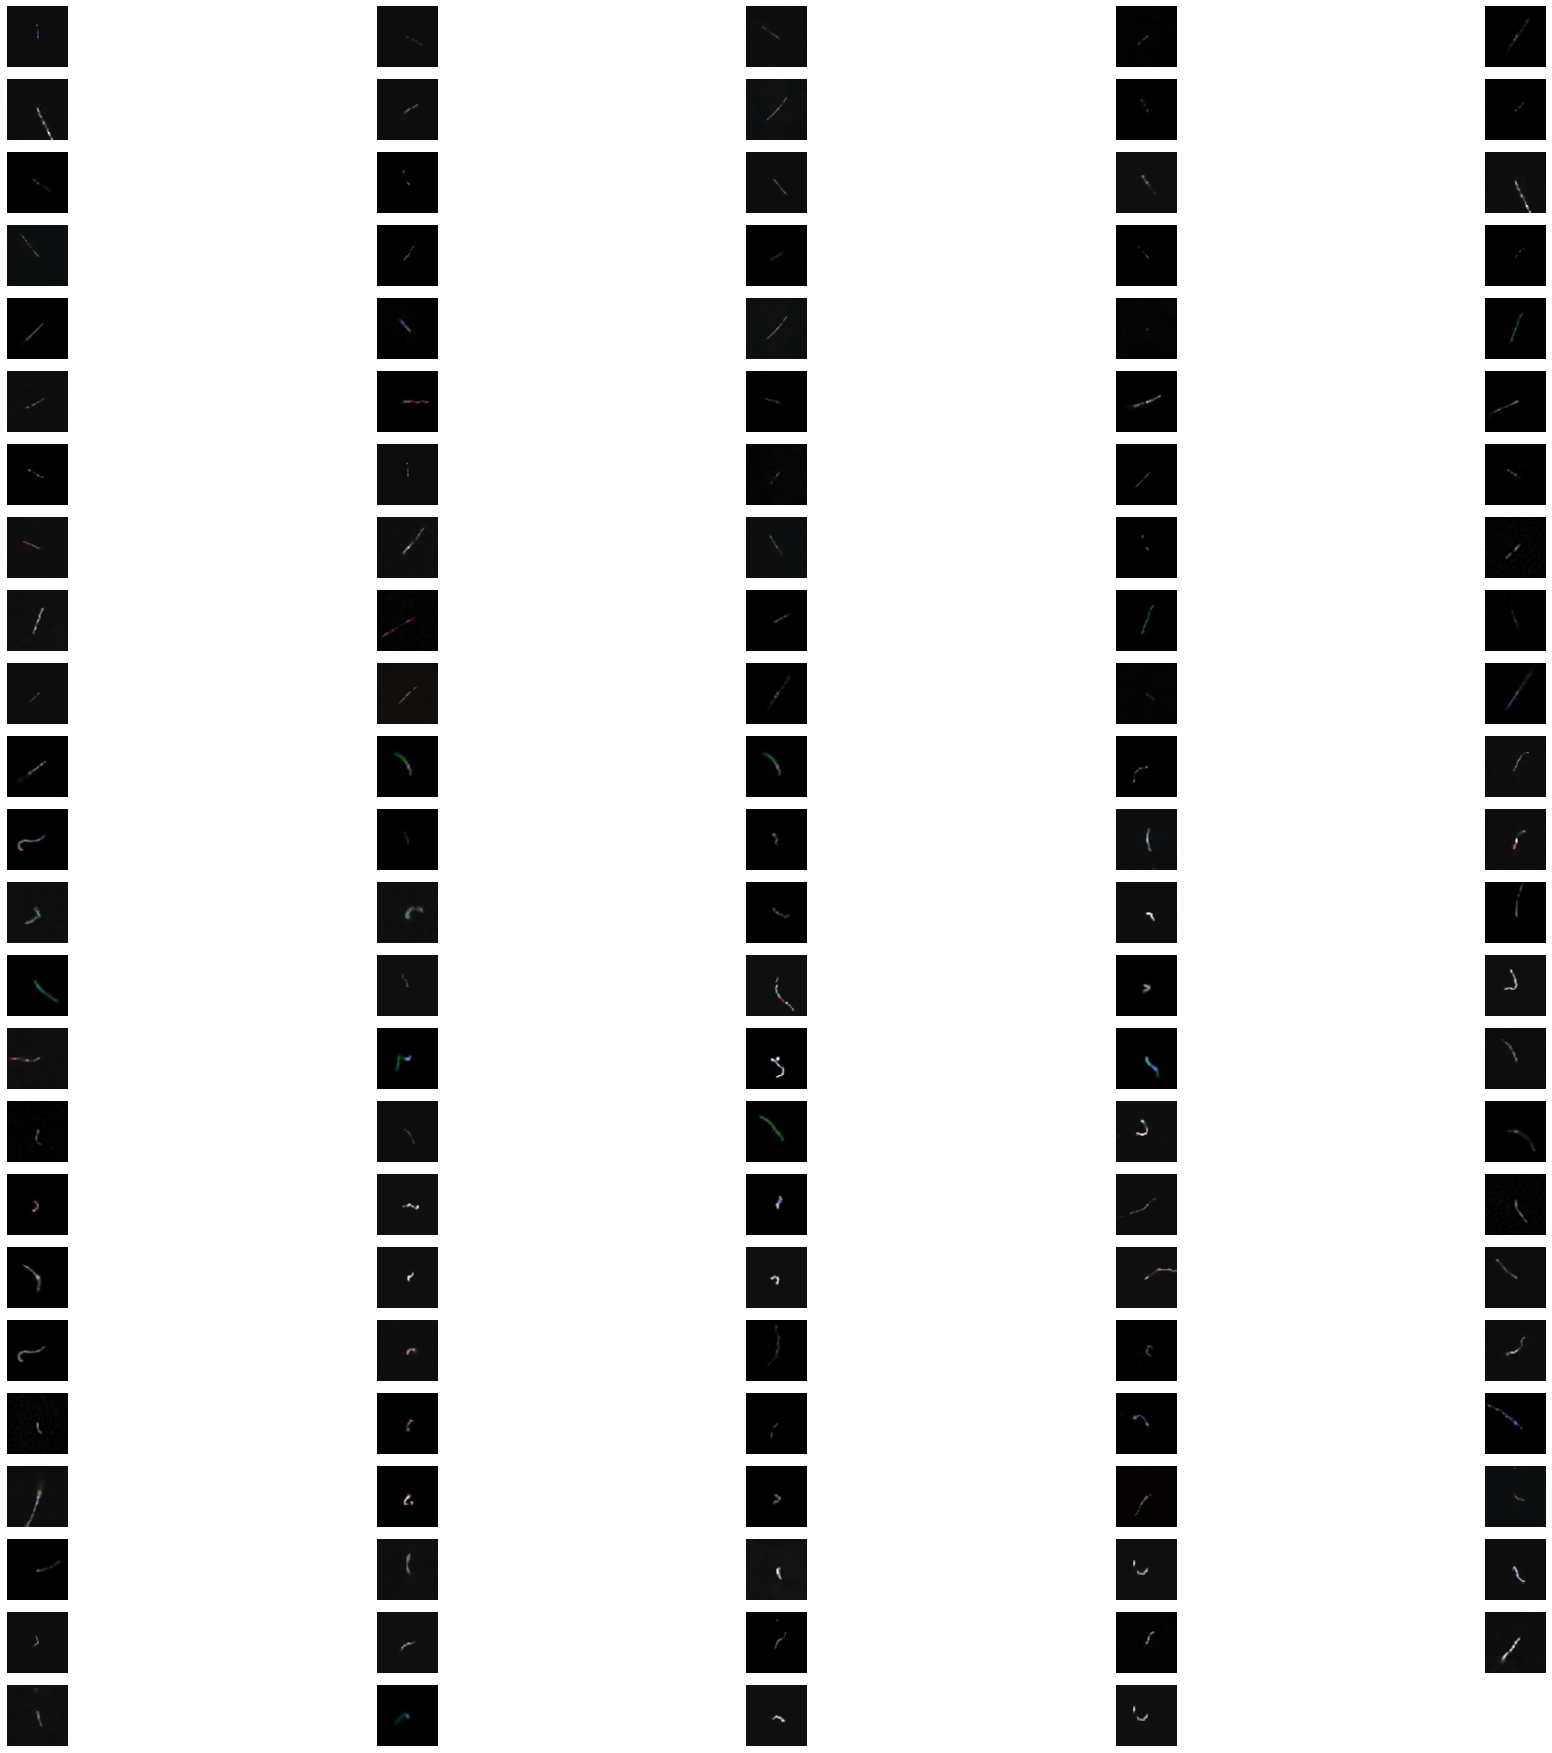

In [12]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

dbscan(embedding, t_files, 140)

[ 0  0  0 ...  0  0 -1]
[ 108  131  177  179  274  278  292  363  371  383  418  500  520  537
  546  684  714  722  739  777  779  798  969 1032 1318 1402 1410 1456
 1527 1692 1754 1760 1823 1976]
34
hit-images-final2/line\22345563.png
hit-images-final2/line\24274103.png
hit-images-final2/line\22437099.png
hit-images-final2/line\11858430.png
hit-images-final2/line\11802060.png
hit-images-final2/line\13873250.png
hit-images-final2/line\22031347.png
hit-images-final2/line\22171544.png
hit-images-final2/line\13842344.png
hit-images-final2/line\22680462.png
hit-images-final2/line\11858430.png
hit-images-final2/line\22500203.png
hit-images-final2/line\17643570.png
hit-images-final2/line\23758907.png
hit-images-final2/line\22605713.png
hit-images-final2/dot\13690344.png
hit-images-final2/line\14276151.png
hit-images-final2/line\23939657.png
hit-images-final2/line\13892698.png
hit-images-final2/line\23478695.png
hit-images-final2/line\11834173.png
hit-images-final2/line\13855443.png
hit-imag

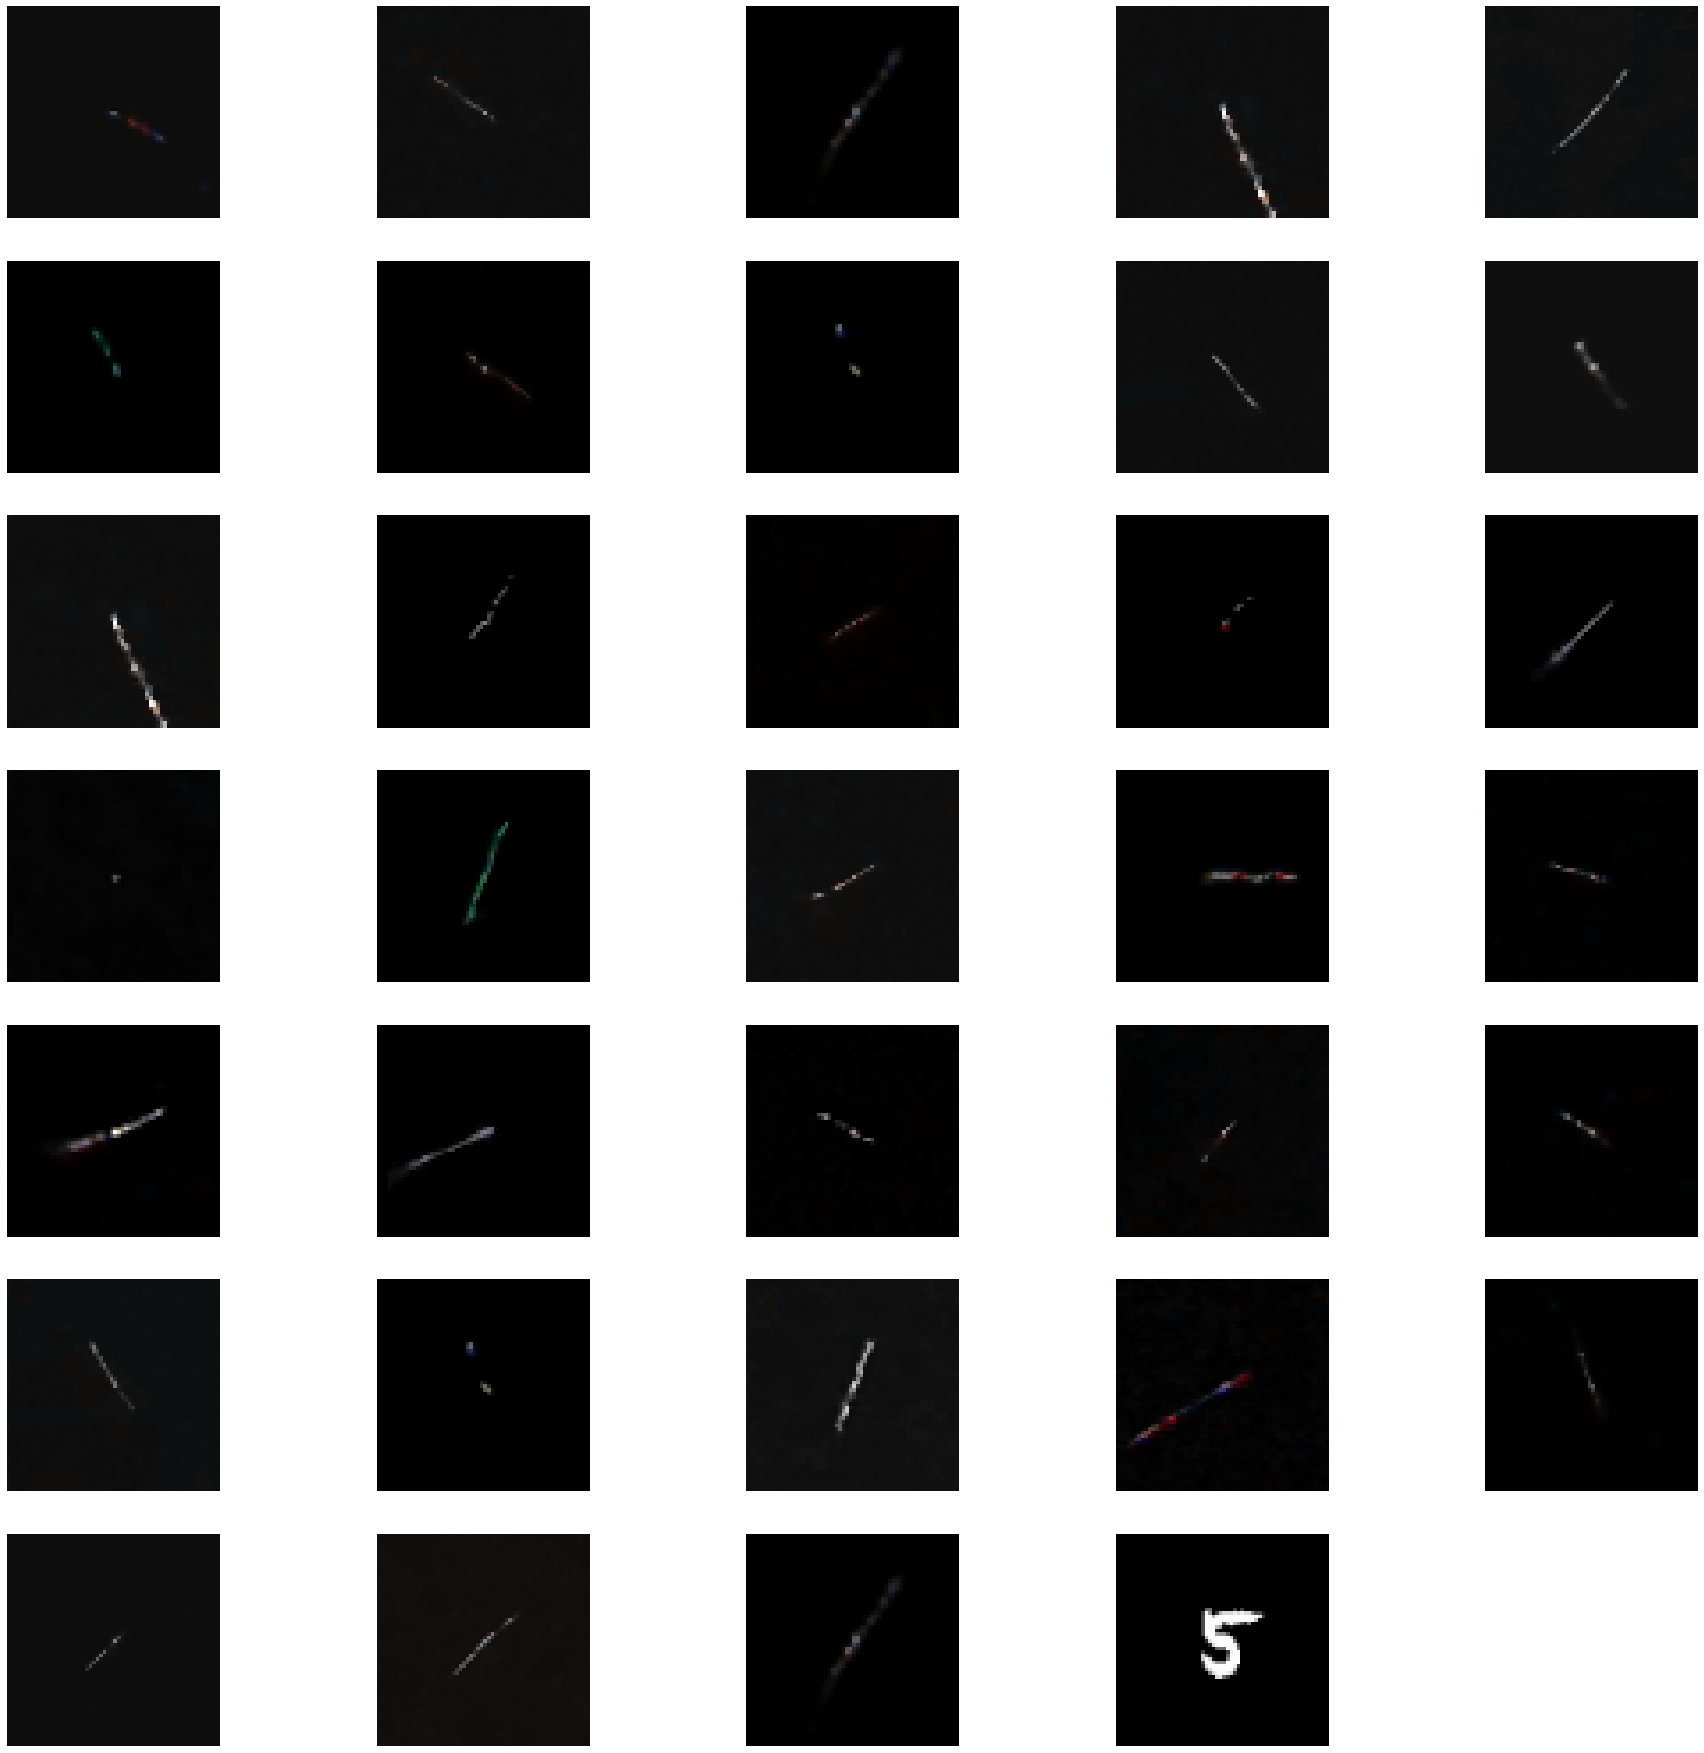

In [13]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

dbscan(embedding, t_files, 150)